<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo02_pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Processamento e limpeza do dataset

### Iniciando pela configuração do Google Colab

In [1]:
# Instalação de libs que não estão presentes no Colab
!pip install -q emoji
!pip install -q transformers --no-cache-dir
!pip install -q sentencepiece
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 175 kB 14.2 MB/s 
     |████████████████████████████████| 4.4 MB 14.5 MB/s 
     |████████████████████████████████| 6.6 MB 90.6 MB/s 
     |████████████████████████████████| 596 kB 68.6 MB/s 
     |████████████████████████████████| 101 kB 68.4 MB/s 
     |████████████████████████████████| 1.2 MB 15.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 14.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
# Configura acesso ao Google Driver onde serão salvos os arquivos grandes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
# Importação de bibliotecas utilizadas no pré-processamento
import re
import emoji
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pt_core_news_sm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from IPython.display import display

In [79]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 350)
# configura tema dos gráficos
sns.set_theme(style="whitegrid")
#configura a barra de progressos para usar no apply
tqdm.pandas()
# Identifica device gpu ou cpu disponível
device_disponivel = 'cuda' if torch.cuda.is_available() else 'cpu'

### Carregar arquivo CSV das bases unificadas e validar

In [80]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/datasets_unificados.csv', 
                    sep = ',', names=['texto', 'classe'], header=1).reset_index(drop=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   9537 non-null   object
 1   classe  9537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.1+ KB


In [84]:
dados[dados['texto'].str.len()<400].sample(n=5)

,texto,classe
8838,"*Reserva de camisas do Mito*\n\nVitor Hugo: 1⃣G 4⃣G ✅\nHorácio: 4⃣G 4⃣M✅\nJairo: 1 camisa G preta\nDjalma : 3⃣G✅\nFernando Campelo: 4⃣ GG✅\nNabell: 1 Branca P✅\nCarlos Augusto: 1 preta e 1 Branca P\nMarcelo Mesquita: 1 G Branca ✅\nEmerson Souza: 1 GG Branca✅\nZito: 1 preta e 1 Branca, ambas M\nGilson Batista : Branca G✅\nHarlen: 2⃣G ✅",0
4591,"Cabra nasce com rosto humano e população diz que ""é o demônio anunciando o fim do mundo"". . A reportagem, feita pelo repórter Jorge Castro (jornal El Chorrillero) , se espalhou pelas redes sociais. ""Foi a própria família que divulgou as primeiras imagens do animal e o chamou de demônio"" informou o repórter argentino. No vídeo abaixo, é possíve...",1
8591,*E aí... Isso não é atentado a democracia Toffolli?*\n\nhttps://noticias.uol.com.br/politica/ultimas-noticias/2018/04/13/tem-que-fechar-o-supremo-tribunal-federal-diz-deputado-do-pt.htm,0
7769,"Adélio Bispo de Oliveira é o nome do petista que tentou matar Jair Bolsonaro hoje em Juiz de Fora.\nEle é filiado ao Partido narcoterrorista dos Trabalhadores.\nÉ natural de Montes Claros, formado na Universidade Federal de Viçosa em Pedagogia!\nÉ militante do PT, responsável pela campanha de Dilma Rousseff em Juiz de Fora.\nPreso em flagrante!",1
9092,"HOJE 17/09 - Paulo Guedes Ministro da Fazenda de Bolsonaro, no Roda Viva da TV Cultura, às 22:10h, após o jornal da Cultura. Favor divulgarem. Obrigado.",1


### Exploração e limpeza de dados

In [85]:
def limpar_textos(texto):
    # Corrige marcadores de nova linha indevidos (textuas e não textuais)
    texto = re.sub(r'(\n|\r)', ' ', re.sub('(\n|\r)', ' ', texto))
    # Remove urls no texto
    texto = re.sub(r'(https|http|ftp)?:\/\/(\w|\.|-|\/|\?|\=|\&|\%)*\b', '', texto)
    # Remove emojis por lib
    texto = emoji.replace_emoji(texto, replace='')
    # Mantem apenas caracteres alfanuméricos com e sem acentuação + pontuação
    texto = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ:\-,." ]', '', texto)
    # Remove reticências e pontuação incorreta
    texto = re.sub(r'(\.\.|\.\.\.|\.\.\.\.|\. \.)', '', texto)
    # Remove números concatenados ao final ou início de palavras
    texto = re.sub(r'(?:([a-z])\d+|\d([a-z]))', r'\1\2', texto)
    # Remove multiplos caracteres em branco
    return re.sub(r'\s+',' ', texto).strip()

dados["texto_limpo"] = dados.texto.progress_apply(limpar_textos)
dados["qtde_limpo"] = dados.texto_limpo.apply(
                                lambda texto: len(re.findall(r"[\w']+", texto)))

  0%|          | 0/9537 [00:00<?, ?it/s]

In [ ]:
display(dados[dados['texto'].str.len()<400].sample(n=5)[['classe', 'texto', 'texto_limpo', 'qtde_limpo']])

,classe,texto,texto_processado
8743,0,"Ouro Preto ontem, Haddad, Dilma e Pimentel, estava lotado, 🙈 acho que não vai ter segundo turno!","Ouro Preto ontem, Haddad, Dilma e Pimentel, estava lotado, acho que não vai ter segundo turno"
8157,0,"Entrevista da candidata Dilma Rousseff ontem (8/09/2018) em Janaúba ao sr. Ambrósio Prates e jornalista e repórter da Rádio Torre FM 91,7 FM.","Entrevista da candidata Dilma Rousseff ontem 8092018 em Janaúba ao sr. Ambrósio Prates e jornalista e repórter da Rádio Torre FM 91,7 FM."
7655,0,"https://www.oantagonista.com/tv/vazou-propaganda-eleitoral-de-bolsonaro/\n\n\nMuito boa a propaganda eleitoral de Bolsonaro, o video está no antagonista","boa a propaganda eleitoral de Bolsonaro, o video está no antagonista"
7966,0,"Ontem eManaus parou com a grande manifestação da senadora e candidata a reeleição - Vanessa Graziotim - em favor de Lula e do PT. \nVejam o vídeo, é de arrepiar com a multidão!","Ontem eManaus parou com a grande manifestação da senadora e candidata a reeleição - Vanessa Graziotim - em favor de Lula e do PT. Vejam o vídeo, é de arrepiar com a multidão"
8663,1,"De Lavada !!!!\n\nTracking BTG que acabou de sair para o mercado financeiro:\n👉Bolsonaro 77%;\n👇Haddad 23%.\nPS: Votos válidos.\n\nTemos que espalhar ao máximo, pois os institutos de pesquisas podem começar a divulgar as “falsas”pesquisas onde H...","De Lavada Tracking BTG que acabou de sair para o mercado financeiro:Bolsonaro 77Haddad 23.PS: Votos válidos.Temos que espalhar ao máximo, pois os institutos de pesquisas podem começar a divulgar as falsaspesquisas onde Haddad já se aproxima de Bo..."


### Carga da spaCy para limpeza de dados

Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)  
Remove stopworks, mas a pontuação é mantida pois é relevante para o modelo.

In [ ]:
nlp = pt_core_news_sm.load()
dados["texto_lematizado"] = dados.texto_limpo.progress_apply(
    lambda texto: " ".join(
          [token.lemma_ for token in nlp(texto)   # lematiza
          if not token.is_stop                    # se não é uma stopword
              and len(token.text) > 1]))          # e se não é caracter perdido
dados["qtde_lematizado"] = dados.texto_lematizado.apply(
    lambda texto: len(re.findall(r"[\w']+", texto)))

  0%|          | 0/9537 [00:00<?, ?it/s]

In [10]:
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
display(dados[dados['texto'].str.len()<400].sample(n=5)[['classe', 'qtde_palavras', 'qtde_lematizado', 'texto', 'texto_lematizado']])

,classe,qtde_palavras,qtde_lematizado,texto,texto_lematizado
8285,1,63,38,"em 27 minutos BOLSONARO:\n- lembrou que o bonner levou chifre\n- que bonner ganha 4x mais que a Renata\n- Mostrou que o kit gay pode ser usado na escola mas não mostrado na TV 22h da noite\n- Que o chefe deles apoiou os militares\nE, pra fechar com chave de ouro, anunciou o apartamento dele na globo, em horário nobre, sem gastar um centavo...😂😂😂😂😂",27 minuto BOLSONARO lembrar bonner levar Chifre bonner ganhar x Renata Mostrou kit gay usar escola mostrar tv h noite chefe de eles apoiar militar pra fechar chave ouro anunciar apartamento de ele globo horário nobre gastar centavo
8559,0,13,9,"Jovem médico, ativista pró-Bolsonaro, é executado covardemente (veja as suas últimas postagens) - https://www.jornaldacidadeonline.com.br/noticias/11800/jovem-medico-ativista-pro-bolsonaro-e-executado-covardemente-veja-as-suas-ultimas-postagens",jovem médico ativistar pró-Bolsonaro executar covardemente último postagem
7631,1,21,12,"Jair Bolsonaro chega a 39% dos votos validos, e fica mais perto de vencer disputa no 1° turno, diz BTG Pactual http://portaldeprefeitura.com.br/2018/09/jair-bolsonaro-chega-a-39-dos-votos-validos-e-fica-mais-perto-de-vencer-disputa-no-1-turno-diz-btg-pactual/",Jair Bolsonaro chegar 39 voto valir ficar vencer disputa turno BTG Pactual
7990,1,14,12,"*Só dar DESLIKE*\n\nAnitta\nhttps://youtu.be/QmrnZobpyW8\n\nDaniella Mercury\nhttps://youtu.be/GlrKJBfiXcI\n\nLetícia Sabatella\nhttps://youtu.be/83Z0ZxqJvPA\n\nLetícia Colin\nhttps://youtu.be/gtj9Ylc3Chc\n\nMarília Mendonça \nhttps://youtu.be/jQGtJq3yZh0\n\nClipe ""EleNão""\nhttps://youtu.be/SBBVS84oYP8",DESLIKE Anitta Daniella Mercury Letícia Sabatella Letícia Colin Marília Mendonça Clipe eleNão
8519,0,16,9,Passando só pra avisar que quem votou no Ciro vai continuar com o nome sujo kkkk👉🏻😎🇧🇷🙊,Passando pra avisar votar Ciro continuar nome Sujo kkkk


### O modelo BERTimbau é sensível ao CASE, precisa ser tratado 

In [11]:
# Remove linhas com mais de 10% de palavras em maiúsculo
antes = dados.shape[0]
dados['qtde_maiusculas'] = dados.texto_lematizado.apply(
    lambda texto: len(re.findall("[A-Z][A-Z\d]+", texto)))
dados = dados[(dados['qtde_maiusculas'] / dados["qtde_lematizado"])<0.1].copy()
# Das linhas que ficaram, capitaliza somente as palavras em MAIÚSCULO
dados['texto_lematizado'] = dados.texto_lematizado.apply(
    lambda texto: re.sub("[A-Z][A-Z\d]+", 
    lambda grupo: grupo.group(0).capitalize(), texto))
dados.drop('qtde_maiusculas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}," +
        f" removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 9537, depois: 8785, removido: 752'

### Remover duplicatas (deveria estar marcado como viral na origem)

In [12]:
# Primeiramente remove duplicatas absolutas do texto
antes = dados.shape[0]
dados = dados.drop_duplicates(subset=['texto_lematizado'])
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8785, depois: 8612, removido: 173'

### Remover linhas com mais de 50% das palavras iguais, quando menos de 100 palavras.

In [13]:
dados_menos_100_palavras = dados[dados["qtde_lematizado"]<100].copy()

# Calcula quantidade de palavras duplicadas
def confere_duplicidade(coluna_busca):
  conjunto_palavras = set(re.findall(r"[\w']+", coluna_busca))
  dados_sem_busca = dados_menos_100_palavras.drop(dados.index[dados['texto_lematizado'] == coluna_busca]).copy()
  dados_sem_busca['duplicado_corrente'] = dados_sem_busca.texto_lematizado.apply(
      lambda texto: len(conjunto_palavras.intersection(set(re.findall(r"[\w']+", texto)))))
  return int(dados_sem_busca['duplicado_corrente'].max())

dados['qtde_palavras_duplicadas'] = dados[dados["qtde_lematizado"]<100].texto_lematizado.progress_apply(confere_duplicidade)
dados_menos_100_palavras = pd.DataFrame() #libera área
antes = dados.shape[0]
dados = dados[((dados['qtde_palavras_duplicadas'] / dados["qtde_lematizado"])<0.5) | (dados['qtde_palavras_duplicadas'].isnull())].copy()
dados.drop('qtde_palavras_duplicadas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

  0%|          | 0/3339 [00:00<?, ?it/s]

'Qtde linhas antes: 8612, depois: 7769, removido: 843'

## Confere a distribuição de palavras nas classes

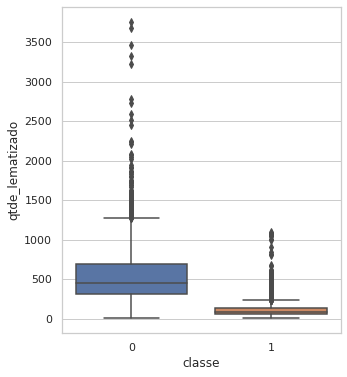

In [76]:
ax, fig = plt.subplots(figsize=[5,6])
ax = sns.boxplot(y=dados["qtde_lematizado"],x=dados["classe"])

In [14]:
def grafico_distribuicao(dfplot):
  dfplot.columns = ['0 - Confiável', '1 - Falso']
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  axes1 = dfplot.plot(
      ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 2000, 100)), 
      title="Distribuição de palavras conforme a classe")
  axes2 = sns.countplot(x="classe", data=dados)
  axes2.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
  axes2.set_title('Distribuição de classes', fontsize=14)
  axes2.set_ylabel('quantidade')

[0, 1]

[3815, 3954]

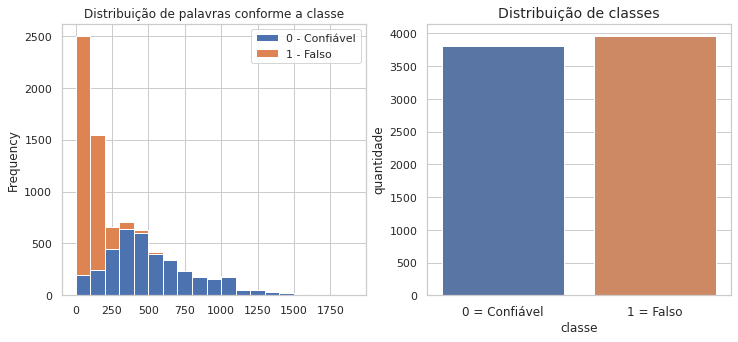

In [15]:
grafico_distribuicao(dados.pivot(columns='classe').qtde_lematizado)
distribuicao = dados.groupby('classe').qtde_lematizado.count()
display(distribuicao.index.to_list(), distribuicao.to_list())

In [16]:
antes = dados.shape[0]
dados = dados.query(
    'qtde_lematizado >= 50 and qtde_lematizado <= 2000'
)
display(f"Qtde antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")
display(f"Maximo de palavras: {dados['qtde_lematizado'].max()}", f"Mínimo de palavras: {dados['qtde_lematizado'].min()}")

'Qtde antes: 7769, depois: 7052, removido: 717'

'Maximo de palavras: 1944'

'Mínimo de palavras: 50'

### Carrega o modelo pré-treinado de sumarização

In [17]:
# configura o device cpu ou gpu conforme disponibilidade
device_disponivel = 'cuda' if torch.cuda.is_available() else 'cpu'
# nome do modelo no portal HuggingFaces
model_name = "seidel/plsum-base-ptt5"

# carrega tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_name)
# carrega pesos do modelo "PLSUM"
model_pt = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device_disponivel)

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

### Separação e salvamento do processo parcial antes de rodar o modelo que leva algumas horas

In [18]:
# Divide o dataframe para executar o modelo somente nos textos grandes e salvar parte do trabalho devido a quedas pela demora
df_menor, df_maior = dados.query('qtde_lematizado <= 300').copy(), dados.query('qtde_lematizado > 300').copy()

# Salva novamente os dados para uso no notebook do próximo passo.
df_menor.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_menor.csv', sep = ',', index=False)
df_maior.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_maior.csv', sep = ',', index=False)

display(f"Menor: {df_menor.shape[0]}; Maior: {df_maior.shape[0]}")

'Menor: 4006; Maior: 3046'

### Principal método que gera os tokens, sumariza e transforma os tokens de volta em palavras

In [32]:
def resumir_textos(texto):
  # tokeniza o texto de entrada
  input_ids = tokenizer([texto],
      return_tensors="pt",        # retorna o tensores pytorch
      max_length=1500,            # tamanho máximo de entrada
      truncation=True             # caso exceder, trunca, já limitei
  )["input_ids"]
  t_tokens = input_ids.to(device_disponivel) 
  # gera tokens de sumarização
  output_ids = model_pt.generate(   
      input_ids=t_tokens,         # tokens de entrada
      max_length=300,             # tamanho máximo
      min_length=50,              # tamanho mínimo
      no_repeat_ngram_size=2,     # n-grans que não deve repetir
      length_penalty=1.5,         # penalti por tamanho, > 1 aproxima max_len
      num_beams=4,                # valor para algoritmo de pesquisa heurística
  )[0]
  # decodifica a saída (converter tokens numéricos para texto)
  resumo = tokenizer.decode(
      output_ids,
      skip_special_tokens=True,           # remove tokens especiais
      clean_up_tokenization_spaces=False  # mantem espaços ao decodificar
  )
  return resumo

In [30]:
#separar o processamento em 3 partes pois demora muito e a conexão com a internet cai e perco tudo
dados01, dados02, dados03 = np.array_split(df_maior, 3)
display(dados01.shape[0],dados02.shape[0],dados03.shape[0])

1016

1015

1015

In [31]:
dados01["texto_resumido"] = dados01['texto_lematizado'].progress_apply(resumir_textos)
dados01["qtde_lematizado"] = dados01.texto_resumido.apply(
    lambda texto: len(re.findall(r"[\w']+", texto))
)
dados01.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_01.csv', sep = ',', index=False)

  0%|          | 0/1016 [00:00<?, ?it/s]

In [45]:
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 0)
dados01.head(1)

texto  \
8  Bolsonaro é um liberal completo, diz presidente do PSL\n\nPartido de pouca expressão nacional, o PSL vive momentos de destaque inédito em sua trajetória de duas décadas.\n\nNo dia 5, a sigla anunciou que "receberia Jair Bolsonaro e sua pré-candidatura à Presidência da República".\n\nA palavra "filiação" não consta no termo divulgado à imprensa, mas o presidente do PSL, o deputado federal Luciano Bivar (PE), diz à Folha que, "tão certo como dois e dois são quatro", o pré-candidato, hoje no PSC, migrará para seu partido em março.\n\nO acordo com o segundo colocado na corrida presidencial até o momento, segundo pesquisas do Datafolha, lançou luz sobre a sigla nanica, mas também provocou uma cisão: o movimento Livres rompeu uma união de quase dois anos com o PSL, que tinha como objetivo refundar o partido com nova liderança.\n\nPara os líderes do grupo, Bolsonaro representa o extremo oposto dos valores liberais, tanto em termos econômicos quanto comportamentais, que deveriam nortear a nova fase do partido.\n\nBivar, entretanto, diz que as críticas são preconceituosas. "Foi um absurdo. A maior parte do partido foi favorável à união. Ter preconceito contra uma pessoa é fundamentalismo. Eu lamento."\n\nBolsonaro representa, diz Bivar, os princípios fundadores do partido: a economia de mercado, as liberdades individuais, a livre expressão de ideias, a autonomia das instituições, o Estado de Direito.\n\n"Não vejo nada no comportamento dele que contradiga a ideologia liberal, na área econômica ou social. É um liberal ao aceitar que cada um faça suas escolhas. Jamais faríamos como o PT, por exemplo, que apoia Cuba, onde homossexuais iam para o paredão."\n\nBivar minimiza declarações do pré-candidato que contrariam essa imagem, como o elogio coronel Carlos Alberto Brilhante Ustra, um dos principais símbolos da repressão durante a ditadura militar, durante votação do processo de impeachment da ex-presidente Dilma Rousseff (PT) na Câmara, em 2016.\n\n"Pela família e inocência das crianças que o PT nunca respeitou, contra o comunismo, o Foro de São Paulo e em memória do coronel Brilhante Ustra, o meu voto é sim", declarou na ocasião.\n\n"Não se deve rotular Bolsonaro por isso", diz Bivar. "Não foi um erro. Cada um tem suas convicções. Não sei se o Ustra foi um torturador ou não. Muitas vezes criam-se factoides e toma-se aquilo como verdadeiro."\n\nSegundo o relatório final da Comissão Nacional da Verdade, na gestão de Ustra o DOI-CODI de São Paulo foi responsável pela morte ou desaparecimento de ao menos 45 presos políticos.\n\nBivar também não vê contradição em um suposto liberal fazer elogios a uma ditadura.\n\n"É preciso entender que naquele período [na ditadura] estávamos diante de uma situação muito delicada. A ameaça comunista era muito grande. Então o povo clamou pelos militares", diz.\n\n"Eu faço alguns elogios ao regime militar também. Toda a infraestrutura do Brasil foi feita no governo militar. Foi um regime de transição, e os próprios militares devolveram o poder de forma absolutamente espontânea. Reconhecer isso não torna ninguém menos liberal."\n\nSobre o fato de Bolsonaro ser réu Supremo Tribunal Federal, sob acusação de incitação ao estupro, avalia que as falas dele tiveram seu sentido deturpado. Em discurso no plenário da Câmara, em 2014, Bolsonaro disse que só não estupraria a colega Maria do Rosário (PT-RS), ex-ministra de Direitos Humanos, porque ela "não merecia".\n\n"Ele nunca falou que iria estuprar a deputada. Nunca fez nenhuma incitação. Agora, se querem deturpar, paciência. Não faz sentido nenhum o acusarem."\n\n"Além disso, como é que pode um cara ser processado por uma declaração dada na tribuna do Congresso, um direito legítimo e constitucional de você expressar suas opiniões? Essas coisas não podem existir no Estado de Direito."\n\nSegundo Bivar, Bolsonaro foi atraído pelo discurso transparente e probo do PSL.\n\n"Se alguém no PSL pensa que vai se locupletar no futuro com uma eventual vitória de Bols

In [50]:
texto = 'Bolsonaro é um liberal completo, diz presidente do PSL\n\nPartido de pouca expressão nacional, o PSL vive momentos de destaque inédito em sua trajetória de duas décadas.\n\nNo dia 5, a sigla anunciou que "receberia Jair Bolsonaro e sua pré-candidatura à Presidência da República".\n\nA palavra "filiação" não consta no termo divulgado à imprensa, mas o presidente do PSL, o deputado federal Luciano Bivar (PE), diz à Folha que, "tão certo como dois e dois são quatro", o pré-candidato, hoje no PSC, migrará para seu partido em março.\n\nO acordo com o segundo colocado na corrida presidencial até o momento, segundo pesquisas do Datafolha, lançou luz sobre a sigla nanica, mas também provocou uma cisão: o movimento Livres rompeu uma união de quase dois anos com o PSL, que tinha como objetivo refundar o partido com nova liderança.\n\nPara os líderes do grupo, Bolsonaro representa o extremo oposto dos valores liberais, tanto em termos econômicos quanto comportamentais, que deveriam nortear a nova fase do partido.\n\nBivar, entretanto, diz que as críticas são preconceituosas. "Foi um absurdo. A maior parte do partido foi favorável à união. Ter preconceito contra uma pessoa é fundamentalismo. Eu lamento."\n\nBolsonaro representa, diz Bivar, os princípios fundadores do partido: a economia de mercado, as liberdades individuais, a livre expressão de ideias, a autonomia das instituições, o Estado de Direito.\n\n"Não vejo nada no comportamento dele que contradiga a ideologia liberal, na área econômica ou social. É um liberal ao aceitar que cada um faça suas escolhas. Jamais faríamos como o PT, por exemplo, que apoia Cuba, onde homossexuais iam para o paredão."\n\nBivar minimiza declarações do pré-candidato que contrariam essa imagem, como o elogio coronel Carlos Alberto Brilhante Ustra, um dos principais símbolos da repressão durante a ditadura militar, durante votação do processo de impeachment da ex-presidente Dilma Rousseff (PT) na Câmara, em 2016.\n\n"Pela família e inocência das crianças que o PT nunca respeitou, contra o comunismo, o Foro de São Paulo e em memória do coronel Brilhante Ustra, o meu voto é sim", declarou na ocasião.\n\n"Não se deve rotular Bolsonaro por isso", diz Bivar. "Não foi um erro. Cada um tem suas convicções. Não sei se o Ustra foi um torturador ou não. Muitas vezes criam-se factoides e toma-se aquilo como verdadeiro."\n\nSegundo o relatório final da Comissão Nacional da Verdade, na gestão de Ustra o DOI-CODI de São Paulo foi responsável pela morte ou desaparecimento de ao menos 45 presos políticos.\n\nBivar também não vê contradição em um suposto liberal fazer elogios a uma ditadura.\n\n"É preciso entender que naquele período [na ditadura] estávamos diante de uma situação muito delicada. A ameaça comunista era muito grande. Então o povo clamou pelos militares", diz.\n\n"Eu faço alguns elogios ao regime militar também. Toda a infraestrutura do Brasil foi feita no governo militar. Foi um regime de transição, e os próprios militares devolveram o poder de forma absolutamente espontânea. Reconhecer isso não torna ninguém menos liberal."\n\nSobre o fato de Bolsonaro ser réu Supremo Tribunal Federal, sob acusação de incitação ao estupro, avalia que as falas dele tiveram seu sentido deturpado. Em discurso no plenário da Câmara, em 2014, Bolsonaro disse que só não estupraria a colega Maria do Rosário (PT-RS), ex-ministra de Direitos Humanos, porque ela "não merecia".\n\n"Ele nunca falou que iria estuprar a deputada. Nunca fez nenhuma incitação. Agora, se querem deturpar, paciência. Não faz sentido nenhum o acusarem."\n\n"Além disso, como é que pode um cara ser processado por uma declaração dada na tribuna do Congresso, um direito legítimo e constitucional de você expressar suas opiniões? Essas coisas não podem existir no Estado de Direito."\n\nSegundo Bivar, Bolsonaro foi atraído pelo discurso transparente e probo do PSL.\n\n"Se alguém no PSL pensa que vai se locupletar no futuro com uma eventual vitória de Bolsonaro, é melhor procurar outro partido. Ninguém se juntará a nós por achar que poderá participar do poder por participar."\n\nEle define o presidenciável como um homem bem intencionado e puro, que "fala o que sente, o que vem da alma". "Essa é a grande diferença. Não é um político que fica em cima do muro. A imprensa terá uma surpresa muito grande e positiva com relação ao comportamento que vamos apresentar."\n\n*POLÊMICA NO FUTEBOL*\n\nLuciano Bivar foi eleito para a Câmara Federal pela primeira vez em 1998. Iniciou seu segundo mandato, como suplente, em julho do ano passado. Candidato a presidente em 2006, sempre pelo PSL, recebeu 0,06% dos votos.\n\nAlém da política, tem longa atuação como dirigente esportivo. Foi quatro vezes presidente do Sport Club do Recife.\n\nEm maio de 2013, foi suspenso do posto por 180 dias, pelo Superior Tribunal de Justiça Desportiva, após ter declarado que pagou a um lobista para "empurrar" um jogador do Sport, Leomar, para a seleção brasileira em 2001.\n\nNa ocasião, Bivar disse que a decisão foi absurda. "Eu fiz marketing. Então a 9ine, do Ronaldinho, também deveria ser suspensa. É uma empresa de marketing", declarou.\n\nEm dezembro de 2013 se afastou do comando do clube para se dedicar à campanha eleitoral do ano seguinte.\n\nNa eleição deste ano pretende se reeleger deputado federal.'
texto_limpo = limpar_textos(texto)
print(resumir_textos(texto_limpo))

o deputado federal Luciano Bivar PE, diz Folha que, "tão certo como dois e dois são quatro", o pré-candidato, hoje no PSC, migrará para seu partido em março. O acordo com o segundo colocado na corrida presidencial até o momento, segundo pesquisas do Datafolha, lançou luz sobre a sigla nanica, mas também provocou uma cisão: o movimento Livres rompeu uma união de quase dois anos e o PSL, que tinha como objetivo refundar o partido com nova liderança. Para os líderes do grupo, Bolsonaro representa o extremo oposto dos valores liberais, tanto em termos econômicos quanto comportamentais, de deveriam nortear a nova fase do partido. Biva, entretanto, afirma que as críticas são preconceituosas. "Foi um absurdo. A maior parte do PT foi favorável união. Ter preconceito contra uma pessoa é fundamentalismo. Eu lamento." Bolsonaro é um liberal completo ao aceitar que cada um faça suas escolhas, jamais faríamos como o PT, por exemplo, não apoia Cuba, onde homossexuais iam para o paredão.


In [ ]:
dados02["texto_resumido"] = dados02['texto_lematizado'].progress_apply(resumir_textos)
dados02["qtde_lematizado"] = dados02.texto_resumido.apply(
    lambda texto: len(re.findall(r"[\w']+", texto))
)
dados02.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_02.csv', sep = ',', index=False)

In [ ]:
dados03["texto_resumido"] = dados03['texto_lematizado'].progress_apply(resumir_textos)
dados03["qtde_lematizado"] = dados03.texto_resumido.apply(
    lambda texto: len(re.findall(r"[\w']+", texto))
)
dados03.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_03.csv', sep = ',', index=False)

In [ ]:
df_maior = pd.concat(
    [dados01, dados02, dados03],
    ignore_index=True,
    copy=True,
)

In [ ]:
df_maior.drop("texto_lematizado", axis=1, inplace=True)
df_maior.rename(columns = {'texto_resumido':'texto_lematizado'}, inplace = True)

dados = pd.concat(
    [df_menor, df_maior],
    ignore_index=True,
    copy=True,
)

### Plota novamente para ver como ficou

In [ ]:
def grafico_distribuicao_boxplot(dados):
  dfplot = dados.pivot(columns='classe').qtde_lematizado
  dfplot.columns = ['0 - Confiável', '1 - Falso']
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  axes1 = dfplot.plot(
      ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 280, 30)), 
      title="Distribuição de palavras conforme a classe")
  axes2 = sns.boxplot(y=dados["qtde_lematizado"],x=dados["classe"])
  axes2.set_ylabel('Qtde_Palavras')  

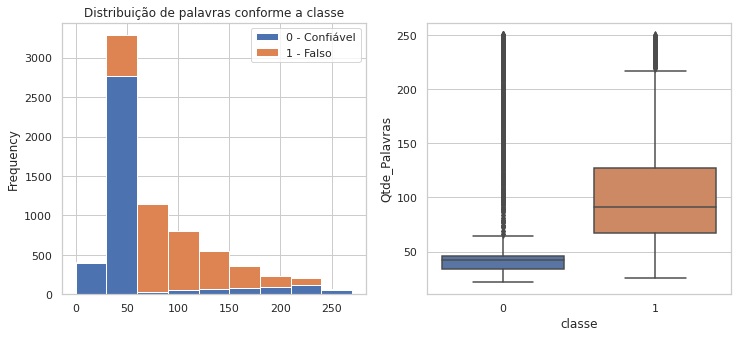

In [ ]:
grafico_distribuicao_boxplot(dados)

### Salva resultado para usar na exploração

In [ ]:
# Salva novamente os dados para uso no notebook do próximo passo.
dados.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado.csv', sep = ',', index=False)